In [1]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from torch import nn
import torch

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

mps


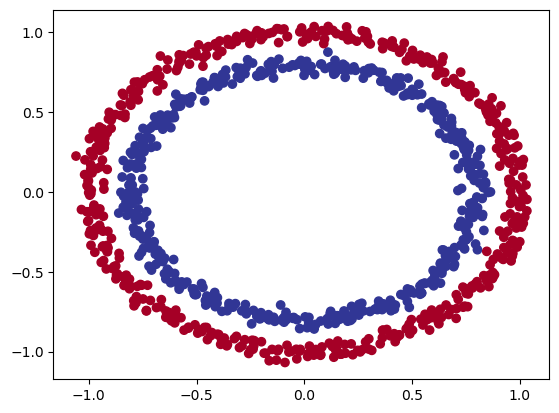

In [3]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap = plt.cm.RdYlBu);

In [4]:
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train[:10], y[:10]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994],
         [-0.8837, -0.4678],
         [-0.3836,  0.6987],
         [ 0.6047,  0.5163],
         [-0.5869,  0.7804],
         [ 0.8833, -0.5178]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [6]:
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [7]:
model_5 = CircleModelV3()
model_5.to(device)
next(model_5.parameters()).device

device(type='mps', index=0)

In [8]:
model_5.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.3993,  0.1478],
                      [-0.3163, -0.6887],
                      [-0.6404, -0.1550],
                      [-0.2488,  0.0194],
                      [-0.0619, -0.0609],
                      [-0.0500,  0.0527],
                      [-0.4356, -0.1166],
                      [ 0.1898,  0.0346],
                      [-0.6198,  0.1688],
                      [-0.4499,  0.4775]], device='mps:0')),
             ('layer_1.bias',
              tensor([ 0.6295,  0.1487,  0.6230,  0.1309,  0.1687, -0.4550, -0.5267, -0.4761,
                      -0.2618,  0.4495], device='mps:0')),
             ('layer_2.weight',
              tensor([[-0.2648,  0.1922, -0.0196, -0.2287,  0.1319,  0.0579,  0.2418, -0.1628,
                       -0.1743,  0.2179],
                      [-0.1595, -0.2222, -0.0141,  0.0854, -0.2216, -0.0089,  0.0352, -0.3097,
                        0.0983,  0.1300],
                      [ 0.2728, -0.2930,

In [9]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_5.parameters(), lr = 0.1)

In [10]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [11]:
epochs = 2000

torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_5.train()

    #Forward Pass
    y_logits = model_5(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) #turn logits -> predict probs -> pred label

    #Compute Loss
    loss = loss_fn(y_logits,
                   y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    #Optimizer zero grad
    optimizer.zero_grad()

    #Loss Backward (Back Props)
    loss.backward()

    #Optimizer step (Gradient Step)
    optimizer.step()

    #Testing
    model_5.eval()
    with torch.inference_mode():
        #Forward Pass
        test_logits = model_5(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #Compute Loss
        test_loss = loss_fn(test_logits,
                   y_test)

        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    #Print out what is happening
    if epoch % 100 == 0:
        print(f"Epoch : {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Epoch : 0 | Loss: 0.69409, Acc: 50.00 | Test Loss: 0.69422, Test Acc: 50.00
Epoch : 100 | Loss: 0.68933, Acc: 55.50 | Test Loss: 0.69155, Test Acc: 50.50
Epoch : 200 | Loss: 0.68768, Acc: 54.62 | Test Loss: 0.69127, Test Acc: 50.00
Epoch : 300 | Loss: 0.68572, Acc: 54.75 | Test Loss: 0.69080, Test Acc: 49.50
Epoch : 400 | Loss: 0.68335, Acc: 55.12 | Test Loss: 0.68990, Test Acc: 50.00
Epoch : 500 | Loss: 0.68017, Acc: 56.38 | Test Loss: 0.68803, Test Acc: 50.00
Epoch : 600 | Loss: 0.67548, Acc: 58.00 | Test Loss: 0.68462, Test Acc: 51.50
Epoch : 700 | Loss: 0.66825, Acc: 60.50 | Test Loss: 0.67833, Test Acc: 56.00
Epoch : 800 | Loss: 0.65533, Acc: 71.38 | Test Loss: 0.66666, Test Acc: 65.50
Epoch : 900 | Loss: 0.63304, Acc: 78.75 | Test Loss: 0.64709, Test Acc: 72.50
Epoch : 1000 | Loss: 0.59832, Acc: 86.12 | Test Loss: 0.61615, Test Acc: 82.50
Epoch : 1100 | Loss: 0.54093, Acc: 90.62 | Test Loss: 0.56533, Test Acc: 87.00
Epoch : 1200 | Loss: 0.45154, Acc: 95.12 | Test Loss: 0.48670, T

In [12]:
from helper_functions import plot_predictions, plot_decision_boundary

In [13]:
model_5.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_5(X_test))).squeeze()

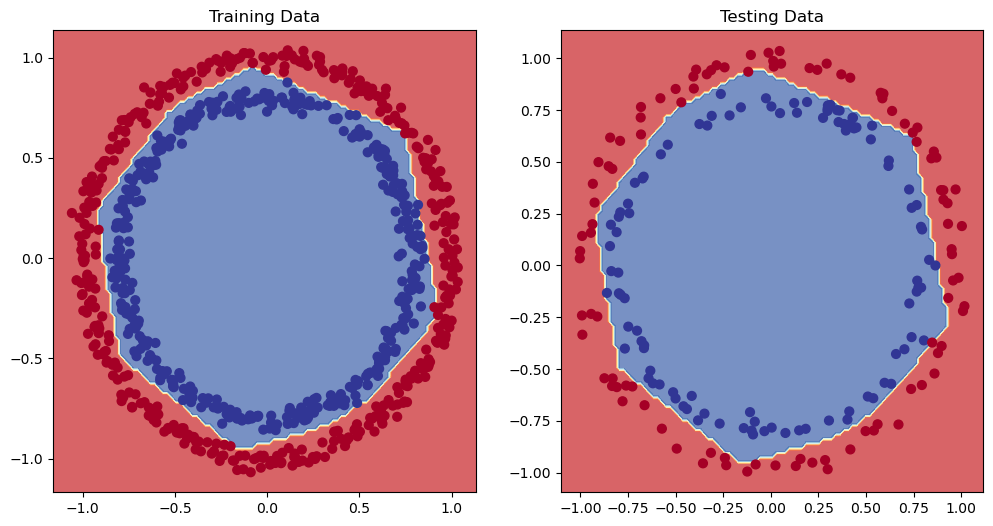

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Training Data")
plot_decision_boundary(model_5, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing Data")
plot_decision_boundary(model_5, X_test, y_test)